<a href="https://colab.research.google.com/github/vhrique/ELF/blob/main/00_baseline_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from tqdm import tqdm
from sklearn.cluster import MiniBatchKMeans
from sklearn.manifold import TSNE
from transformers import AutoModel, AutoTokenizer

In [2]:
url = 'https://drive.google.com/uc?export=download&id=1LacuZm4G4L-FtBIIKXnOTwr99cw0onl6'

response = requests.get(url)

if response.status_code == 200:
    text_content = response.text
else:
    print(f"Failed to retrieve the file. Status code: {response.status_code}")

In [3]:
all_lines = text_content.splitlines()

entry = {}
entries = []
for i, line in enumerate(all_lines):
    if line == '':
        entries.append(entry)
        entry = {}
        continue
    values = line.split('- ')
    value = '- '.join(values[1:])
    key = values[0].strip()
    if key == 'DO':
        entry['DO'] = value
    if key == 'AB':
        entry['AB'] = value
    if key == 'KW':
        if 'KW' not in entry:
            entry['KW'] = []
        entry['KW'].append(value)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
model = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased").to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

In [5]:
def get_encodings(entry):

    abstract = entry['AB'].lower()
    keywords = [kw.lower() for kw in entry['KW']]

    abstract_tokens = tokenizer([f'abstract: {abstract}\n'], return_tensors="pt").input_ids
    keywords_tokens = [tokenizer([f'keyword: {keyword}\n'], return_tensors="pt").input_ids for keyword in keywords]
    input_tensors = torch.concat(keywords_tokens + [abstract_tokens], dim=1)

    with torch.no_grad():
        embeddings = model(input_tensors[:,:512].to(device)).last_hidden_state

    start = 0
    end = 0
    keywords_embeddings = []
    for keyword in keywords_tokens:
        start = end
        end = start + keyword[0].shape[0]
        keywords_embeddings.append(embeddings[0][start:end].mean(axis=0))

    start = end
    abstract_embedding = embeddings[0][start:].mean(axis=0)


    return abstract_embedding, keywords_embeddings

_ = get_encodings(entries[2])

In [6]:
embeddings = []
text = []
text_type = []
doi = []
indices = []

for i, entry in tqdm(enumerate(entries), total=len(entries)):

    if 'DO' not in entry or 'KW' not in entry:
        continue

    abstract_embedding, keywords_embeddings = get_encodings(entry)

    embeddings.append(abstract_embedding.tolist())
    text.append(entry['AB'])
    text_type.append('abstract')
    doi.append(entry['DO'])
    indices.append(i)

    for keyword, keyword_embeddings in zip(entry['KW'], keywords_embeddings):
        embeddings.append(keyword_embeddings.tolist())
        text.append(keyword)
        text_type.append('keyword')
        doi.append(entry['DO'])
        indices.append(i)


df = pd.DataFrame({
    'entries': indices,
    'doi': doi,
    'type': text_type,
    'text': text,
    'emb': embeddings
})
# df.to_csv('abstract_keyword_embeddings.csv', index=False)


100%|██████████| 898/898 [00:30<00:00, 29.75it/s]


In [7]:
isna = np.isnan(np.array(embeddings)).sum(axis=1) > 0
df = df.loc[~isna]

In [8]:
X2d = TSNE(n_components=2).fit_transform(np.array(df.emb.tolist()))

In [9]:
df['tsne1'] = X2d[:,0]
df['tsne2'] = X2d[:,1]

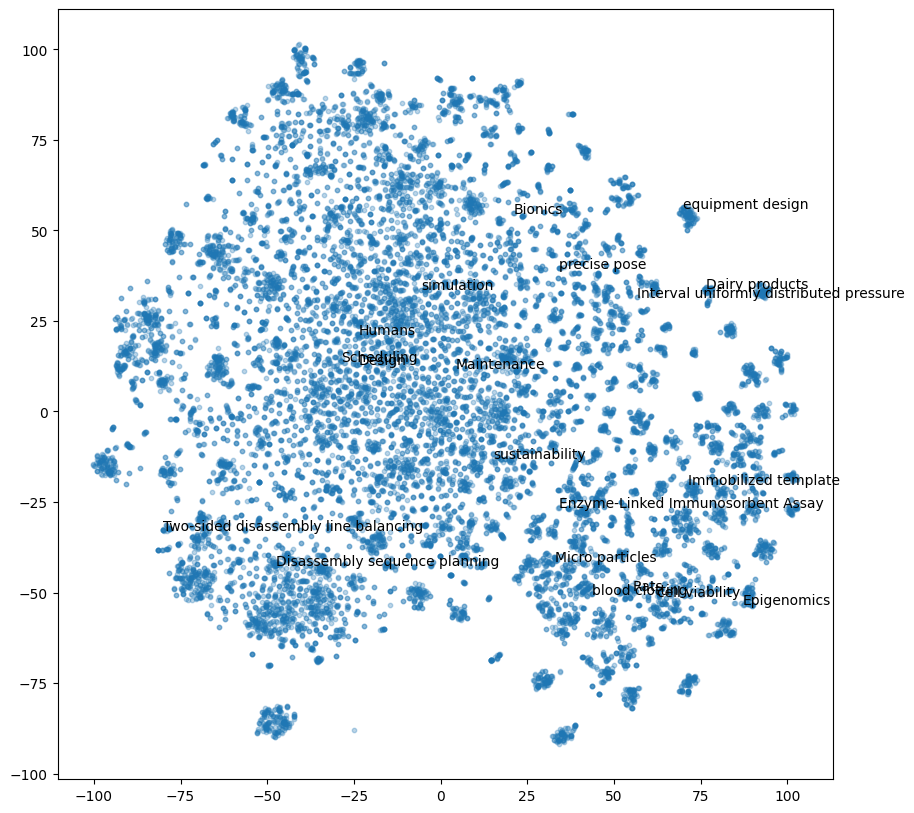

In [10]:
plt.figure(figsize=(10,10))
plt.scatter(df.query('type=="keyword"').tsne1, df.query('type=="keyword"').tsne2, s=10, alpha=0.3)
for _ in range(20):
    row = df.query('type=="keyword"').sample(1).iloc[0]
    plt.text(row.tsne1, row.tsne2, row.text)
plt.show()

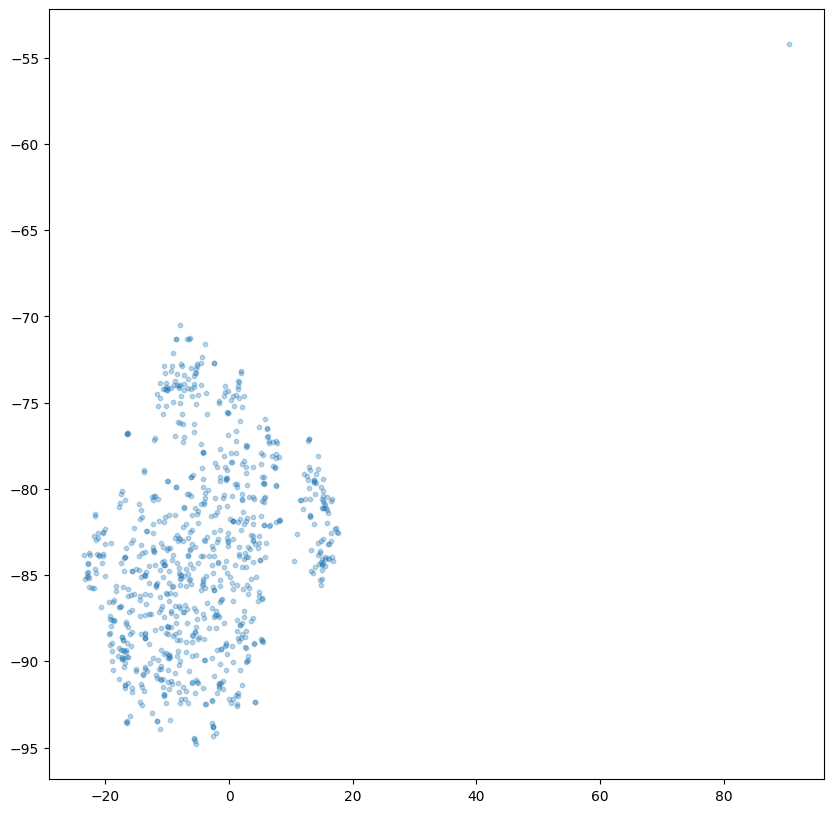

In [20]:
plt.figure(figsize=(10,10))
plt.scatter(df.query('type=="abstract"').tsne1, df.query('type=="abstract"').tsne2, s=10, alpha=0.3)
plt.show()

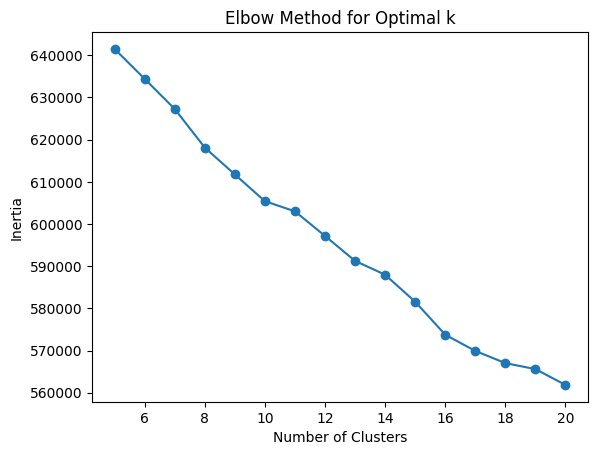

6 ['Computer aided manufacturing', 'Production control', 'AND/OR Trees', 'Architectural design', 'Sustainable Manufacturing']
1 ['Disassembly line balancing', 'Selective disassembly planning', 'Disassembly', 'Disassembly device', 'Human-robot collaboration']
3 ['Websites', 'Cell formation problem', 'Simulation', 'Optimization techniques', 'Feature map']
4 ['Energy efficiency', 'Techno-economics', 'Building materials', 'Environmental aspects', 'recycling']
5 ['Nonlinear programming', 'Multi-objectives optimization', 'Mixed-Integer Linear Programming', 'Mixed integer quadratic programming', 'Evolutionary algorithms']
0 ['Scatter search', 'improved artificial bee colony algorithm', 'Particle swarm optimization', 'Genetic algorithms', 'Swarm optimization']
9 ['cell cycle G1 phase', 'amino acid sequence', 'cell cycle G0 phase', 'triple negative breast cancer', 'Adenocarcinoma']
8 ['ubiquitin protein ligase E3', 'synaptosomal associated protein 25', 'Trichosporon', 'Chromatin Assembly and Di

<ipython-input-18-896d0f21c0a5>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_keyword.loc[:,'cluster'] = clusters


In [18]:
def find_optimal_clusters(X, min_k=5, max_k=20, plot=True):
    inertias = []
    for k in range(min_k, max_k+1):
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)

    if plot:
        plt.plot(range(min_k, max_k+1), inertias, marker='o')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Inertia')
        plt.title('Elbow Method for Optimal k')
        plt.show()

    # Use "elbow" heuristic to pick optimal k (or default to 3)
    diffs = np.diff(inertias)
    optimal_k = np.argmin(diffs[1:] - diffs[:-1]) + min_k if len(diffs) > 1 else 1

    final_kmeans = MiniBatchKMeans(n_clusters=optimal_k, random_state=0)
    clusters = final_kmeans.fit_predict(X)
    return optimal_k, clusters

df_keyword = df.query('type == "keyword"')
optimal_k, clusters = find_optimal_clusters(np.array(df_keyword.emb.tolist()))

df_keyword.loc[:,'cluster'] = clusters

for cluster in df_keyword.cluster.unique():
    print(cluster, df_keyword.query(f'cluster == {cluster}').sample(5).text.tolist())

In [19]:
kmeans = MiniBatchKMeans(n_clusters=40, random_state=0)
clusters = kmeans.fit_predict(np.array(df_keyword.emb.tolist()))
df_keyword.loc[:,'cluster'] = clusters
for cluster in df_keyword.cluster.unique():
    print(cluster, df_keyword.query(f'cluster == {cluster}').sample(10).text.tolist())

1 ['Genetic algorithm', 'Frequency response calibration', 'Dynamic wagon-flow allocation', 'Maintenance plan', 'computer simulation', 'Modular technologies in field infrastructure development', 'vehicle dynamics simulation', 'Numerical modelling', 'Repetitive movements', 'flexibility matrix']
21 ['One-dimensional analytical solution', 'Evolutionary optimizations', 'Constrainedshort path', 'Sensor errors', 'Virtual surgeries', 'flatworm', 'Hump sequencing', 'Restart mechanism', 'Structural dependence', 'Decision support systems']
4 ['Robotics', 'Cellular manufacturing', 'Touch screens', 'Agricultural robots', 'Human-robot responsive collaboration', 'Machine learning for engineering applications', 'Laboratory environment', 'Machines and mechanisms', 'Computing technology', 'Geometric constraints']
15 ['Benchmarking', 'Decision making', 'Background noise', 'Sequencing', 'Optimization', 'Basis vector', 'Differential approach', 'Smoothing index', 'System reduction', 'simulation optimization